## Library download

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import os, time, random

import tensorflow as tf
from PIL import Image
from skimage import io

#########################
# DL Libraries
#########################
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras import backend as K

# source https://www.kaggle.com/code/suvoooo/detectpneumonia-inceptionresnetv2-class-imbalance/notebook#Inference-from-1st-training

In [6]:
cwd = os.getcwd()
print(cwd)
train_path = cwd+'/' + 'train/'
valid_path = cwd+'/' + 'val/'
test_path = cwd+'/' + 'test/'
print(train_path)

c:\Users\marlo\OneDrive\Desktop\Anaconda\Fun\Deep Learning\CNN\archive\chest_xray
c:\Users\marlo\OneDrive\Desktop\Anaconda\Fun\Deep Learning\CNN\archive\chest_xray/train/


In [7]:
### check number of train, valid and test images 
labels = ['NORMAL', 'PNEUMONIA']

def check_ims_in_folder(labels):
    '''returns tuples of images in each folder'''
    train_ims_normal = os.listdir(train_path+labels[0]+'/')
    train_ims_pneumonia = os.listdir(train_path+labels[1]+'/')
    
    valid_ims_normal = os.listdir(valid_path+labels[0]+'/')
    valid_ims_pneumonia = os.listdir(valid_path+labels[1]+'/')
    
    test_ims_normal = os.listdir(test_path+labels[0]+'/')
    test_ims_pneumonia = os.listdir(test_path+labels[1]+'/')
    
    return (train_ims_normal, train_ims_pneumonia), (valid_ims_normal, valid_ims_pneumonia), (test_ims_normal, test_ims_pneumonia)

### Inspect the distribution

[0.15 1.15 2.15 3.15 4.15 5.15]


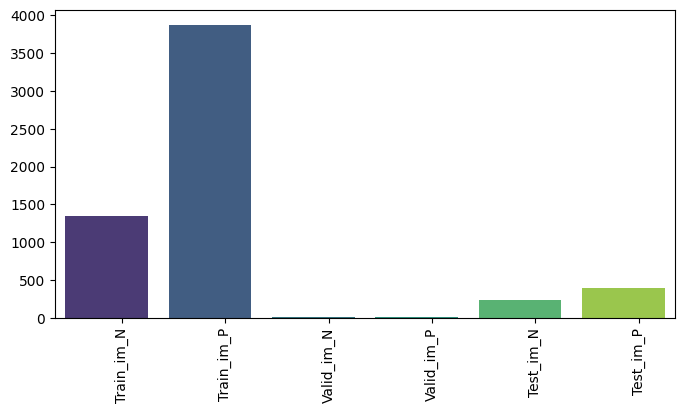

train_im_N:  1341
train_im_P:  3875
valid_im_N:  8
valid_im_P:  8
test_im_N:  234
test_im_P:  390


In [8]:
(train_im_n, train_im_p), (valid_im_n, valid_im_p), (test_im_n, test_im_p) = check_ims_in_folder(labels)


index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Valid_im_N', 'Valid_im_P', 'Test_im_N', 'Test_im_P']

fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(valid_im_n), len(valid_im_p), len(test_im_n), len(test_im_p)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('valid_im_N: ', len(valid_im_n))
print ('valid_im_P: ', len(valid_im_p))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))

In [9]:
tot_normal_train = len(train_im_n) + len(valid_im_n) 
tot_pneumonia_train = len(train_im_p) + len(valid_im_p)
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)

total normal xray images:  1349
total pneumonia xray images:  3883


In [10]:
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    if folder=='val':
        path = valid_path
        normal = valid_im_n
        pneumonia = valid_im_p
    elif folder=='train':
        path = train_path
        normal = train_im_n
        pneumonia = train_im_p
    else:
        path = test_path
        normal = test_im_n
        pneumonia = test_im_p
    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p

In [11]:
im_shape_valid_x_n, im_shape_valid_y_n, im_shape_valid_x_p, im_shape_valid_y_p = check_im_size('val', labels)
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p = check_im_size('test', labels)  

{1632, 1288, 1736, 1776, 1328, 1272, 1564, 1240} {928, 1416, 1225, 1040, 1104, 1302}


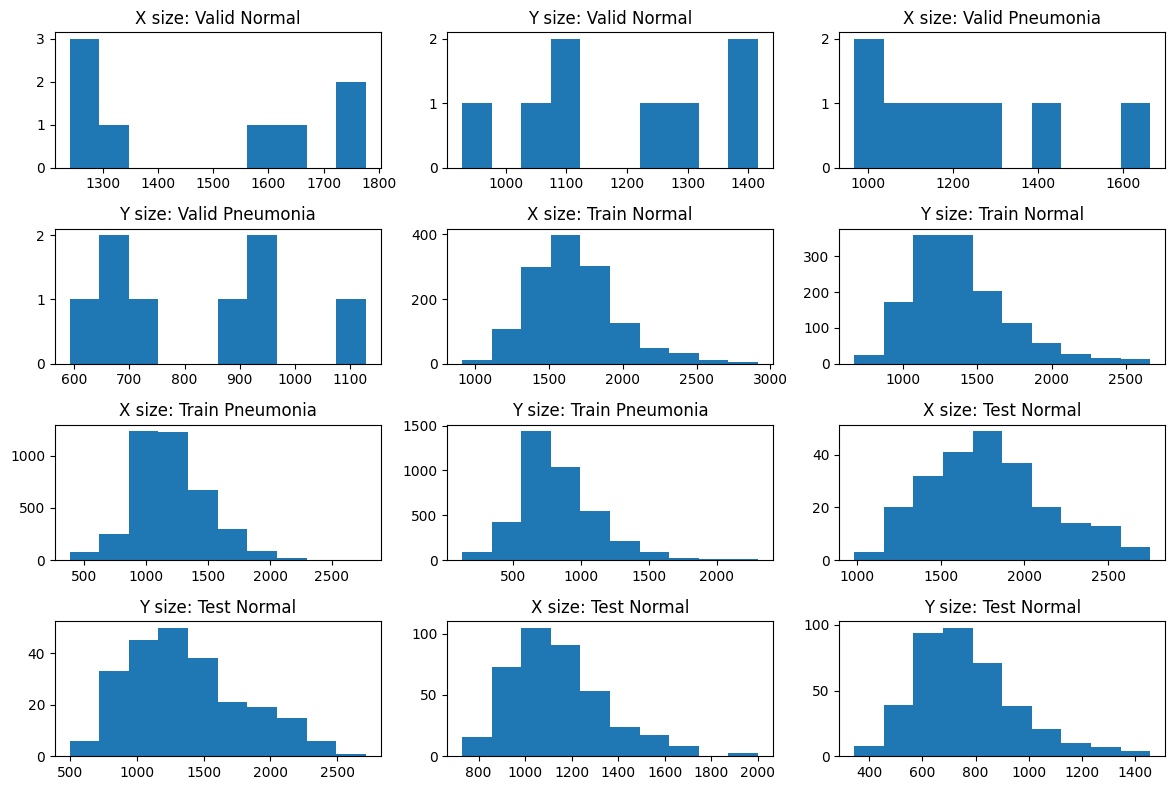

In [12]:
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(431)
plt.hist(im_shape_valid_x_n)
plt.title('X size: Valid Normal')
fig.add_subplot(432)
plt.hist(im_shape_valid_y_n)
plt.title('Y size: Valid Normal')
fig.add_subplot(433)
plt.hist(im_shape_valid_x_p)
plt.title('X size: Valid Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_valid_y_p)
plt.title('Y size: Valid Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(436)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(437)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(438)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(439)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Normal')
plt.tight_layout()
print (set(im_shape_valid_x_n), set(im_shape_valid_y_n))

### Image visualization

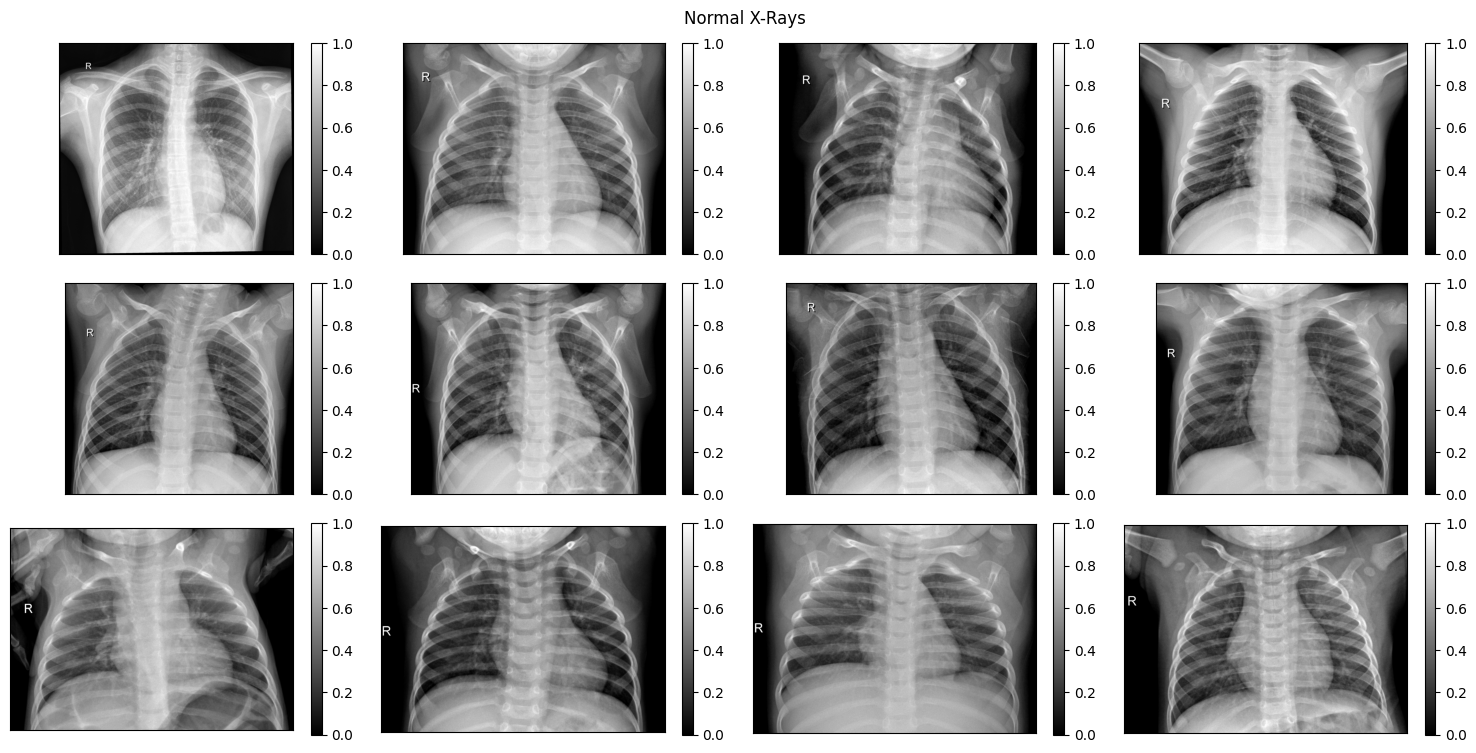

check shape of an example image:  (1049, 1426)


In [13]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(train_path +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

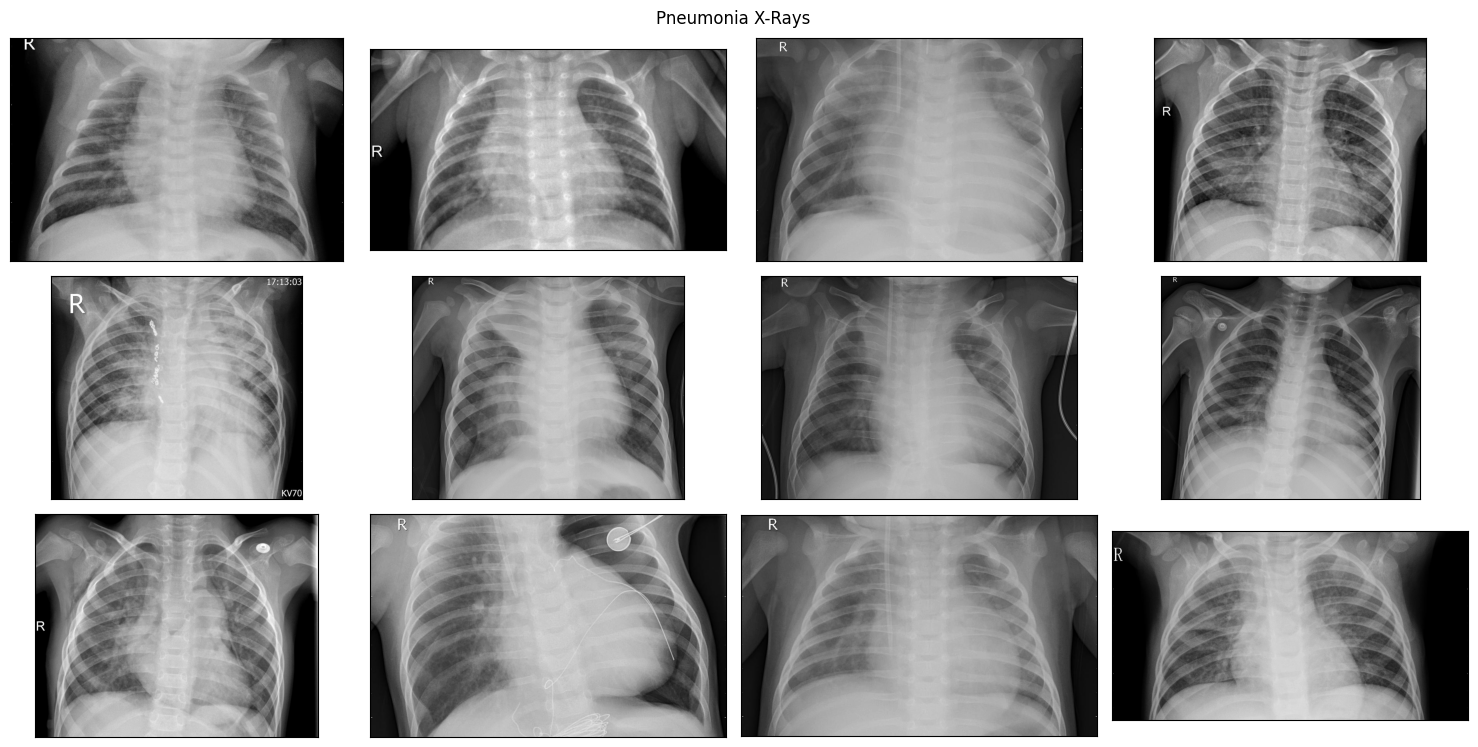

In [14]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_p_selected = random.sample(train_im_p, 12)
for i, img in enumerate(train_im_p_selected):
    sample = os.path.join(train_path +labels[1]+'/', img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(int(npics/3), 4, count, xticks=[],yticks=[])   
    plt.imshow(sample_img, cmap='gray')
    count +=1
fig.suptitle('Pneumonia X-Rays')
plt.tight_layout()
plt.show()

### Data Loading

In [19]:
target_size = (300, 300)

input_shape = (300, 300, 1)

batch_size = 64

print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory(train_path, 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='binary')



print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory(valid_path, 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='binary')

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory(test_path, 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='binary')

Training Dataset.....
Found 5216 files belonging to 2 classes.
Val Dataset....
Found 16 files belonging to 2 classes.
Test Datast...
Found 624 files belonging to 2 classes.


### Adapting Train and Val

In [23]:
# Number of batches in train/val
num_elements = tf.data.experimental.cardinality(train_dir).numpy()
print (num_elements)
num_elements_val = tf.data.experimental.cardinality(val_dir).numpy()
print (num_elements_val)

82
1


In [20]:
# Get class names
class_names = train_dir.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [22]:
new_train_ds = train_dir.concatenate(val_dir)

print (new_train_ds, train_dir)

train_size = int(0.85 * 83) # 83 is the elements in dataset (train + valid)
val_size = int(0.15 * 83)

train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
70
12


### Standartization and Augmentation

In [16]:
#### define a function that will be added as lambda layer later
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

(64, 300, 300, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 1)


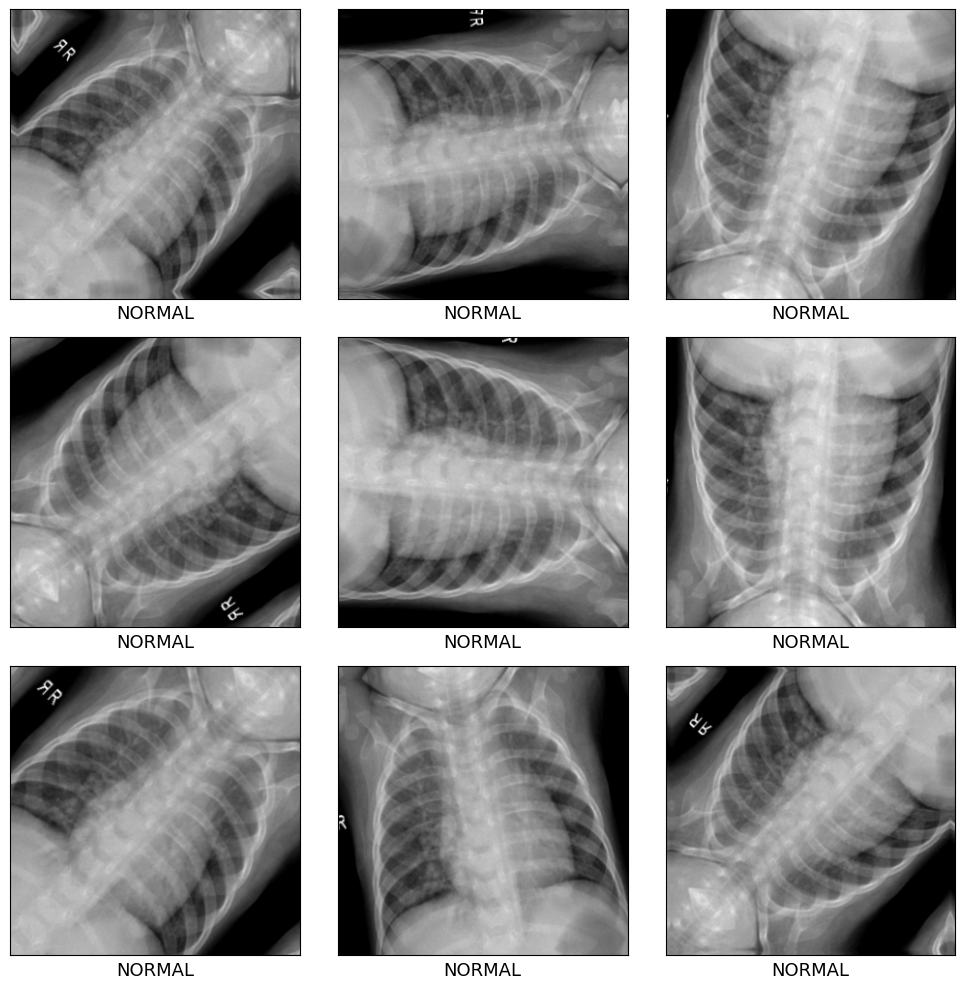

(64, 300, 300, 1) (300, 300, 1)


In [24]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])


### let's try something fancy 
from itertools import islice, count

train_iter_35im, train_iter_35label = next(islice(train_ds, 35, None)) # access the 35th element (just a random check) from the iterator



print (train_iter_35im.shape, type(train_iter_35im))
print (train_iter_35label.shape)

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_35label = train_iter_35label.numpy()


plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    aug_img = data_augmentation(train_iter_35im)
    plt.imshow(aug_img[0], cmap='gray')
    plt.xlabel(class_names[np.argmax(train_iter_35label)], fontsize=13)
plt.tight_layout()    
plt.show()

print (aug_img.shape, aug_img[0].shape)

In [25]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)

In [30]:
#### check the numbers again
print (train_data_batches)
print(valid_data_batches)

num_elements_train_data_batches = tf.data.experimental.cardinality(train_data_batches).numpy()
print (num_elements_train_data_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
70


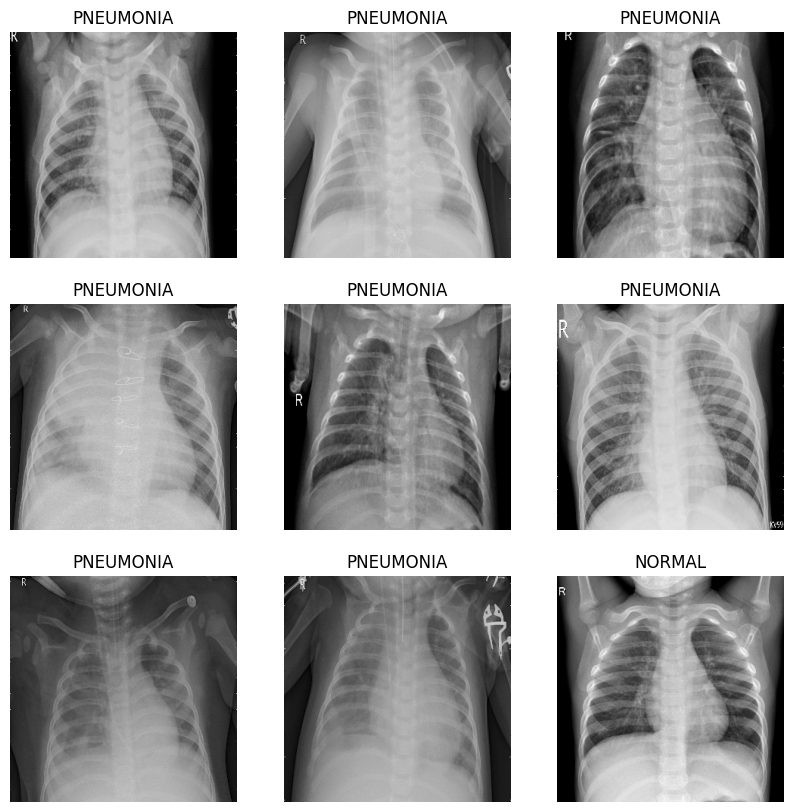

In [31]:
### check if the data batches work properly or not 

plt.figure(figsize=(10, 10))
for images, labels in train_data_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")  

## Building the Model

In [34]:
input_shape = (300, 300, 3)

Xception= tf.keras.applications.Xception(weights = 'imagenet',input_shape = input_shape,include_top = False)

def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
        ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = Xception(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)
    
    return model
model = build_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 1)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 1)      0         
 a)                                                              
                                                                 
 lambda (Lambda)             (None, 300, 300, 1)       0         
                                                                 
 lambda_1 (Lambda)           (None, 300, 300, 1)       0         
                                                                 
 lambda_2 (Lambda)           (None, 300, 300, 1)       0     

### Weightes Cross-Entropy
To account for biased distribution of Positive/Negative classes

In [32]:
freq_neg = tot_normal_train/(tot_normal_train + tot_pneumonia_train)
freq_pos = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train)

pos_weights = np.array([freq_neg])
neg_weights = np.array([freq_pos])

print ('check positive weight: ', pos_weights, len(pos_weights))
print ('check negative weight: ', neg_weights)


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)): # we have only 1 class 
            # for each class, add average weighted loss for that class 
            loss += - (K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)) + 
                              (neg_weights[i] * (1-y_true[:, i]) * K.log(1-y_pred[:, i] + epsilon)) ) )
        return loss
    return weighted_loss


check positive weight:  [0.25783639] 1
check negative weight:  [0.74216361]


### Prepare for Training

In [ ]:
from tensorflow import keras

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1**(epoch / s)
#     return exponential_decay_fn

# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
# exponential_decay_fn = exponential_decay(lr0=0.01, s=40)
# lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=3, min_lr=1e-8, verbose=1)
model_save = keras.callbacks.ModelCheckpoint('./Xception_model.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

# Optimizers
# optimizer= keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9,nesterov=True) # learning_rate=1e-2, 
optimizer= keras.optimizers.Adam(lr=1e-3, beta_1 = 0.9, beta_2=0.999)
# optimizer= keras.optimizers.Nadam() # lr=1e-2, beta_1 = 0.9, beta_2=0.999


### Compile and Train

In [ ]:
model = build_model()
model.summary()

model.compile(optimizer=optimizer,
                 loss=get_weighted_loss(pos_weights, neg_weights), 
                 metrics=METRICS)

In [ ]:
start_time = time.time()
history = model.fit(train_data_batches, 
                    epochs=100, 
                    validation_data=valid_data_batches,
                    callbacks=[model_save, early_stopping_cb, lr_scheduler])

end_time = time.time()

In [ ]:
print ('total time taken: in Minutes', (end_time-start_time)/60.)

### Training and Validation (Loss & Accuracy)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221)

plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(222)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

fig.add_subplot(223)
plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
plt.title("Training and validation Precision")

fig.add_subplot(224)
plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
plt.title("Training and validation Recall")

plt.show()

In [ ]:
model.evaluate(test_data_batches)

## Check for saved weights

In [ ]:
model.load_weights("Xception_model.h5")
model.evaluate(test_data_batches)

## Test instances for my family

In [ ]:
y_pred = model.predict(test_data_batches)
print ('check y_pred: ', y_pred[0:10])

In [ ]:
#### set a different threshold 

y_pred_th = (y_pred > 0.75).astype(np.float32)
print (y_pred_th[0:10])

In [ ]:
plt.figure(figsize=(16, 12))
for images, labels in test_data_batches.take(1):
    for i in range(10):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        
        y_pred_batch = model.predict(tf.expand_dims(images[i], axis=0, ))
        y_pred_75th = (y_pred_batch > 0.75).astype(np.uint8)
        original_label = class_names[labels[i].numpy().astype("uint8")[0]]
        predicted_label = class_names[y_pred_75th[0].astype("uint8")[0]]
        plt.title(f'Original: {original_label}; Predicted: {predicted_label}')
        plt.axis("off")          